In [1]:
import cupy as cp
from dataset import load_mnist
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import numpy as np
import matplotlib.pyplot as plt

cp.cuda.Device(0).use()

In [2]:
train_data, test_data, train_label, test_label = load_mnist()
train_data, valid_data, train_label, valid_label = train_test_split(train_data, train_label, test_size=0.2)

In [3]:
def label_to_one_hot(y, n_class):
    one_hot = cp.zeros((y.shape[0], n_class))
    for i in range(len(y)):
        one_hot[i][int(y[i])] = 1
    
    return one_hot

    
def softmax_with_loss(out, y):
    
    max_val = cp.max(out, axis=1).reshape(-1, 1)
    exp_out = cp.exp(out - max_val)
    sum_exp_out = cp.sum(exp_out, axis=1).reshape(-1, 1)
    out = exp_out / sum_exp_out
    
    log_out = cp.log(out + 1e-7)
    
    loss = cp.sum(-log_out * y)
    
    grad = out - y
    
    return loss, grad, out


class SimpleNN(object):
    def __init__(self):
        self.params = {}
        self.params['W'] = cp.random.randn(784, 10) / cp.sqrt(784)
        
        self.params['b'] = cp.random.randn(10)
     
        self.grads = {}
    
    def forward(self, x, y):
        
        y = label_to_one_hot(y, 10)
        
        self.x = x
    
        out = cp.dot(x, self.params['W']) + self.params['b'] 

        loss, grad, out = softmax_with_loss(out, y)
    
        self.loss_grad = grad / x.shape[0]
        
        return loss / x.shape[0], out
        
    def backward(self):
        
        self.grads['W'] = cp.dot(self.x.T, self.loss_grad)
        self.grads['b'] = cp.sum(self.loss_grad, axis=0)

In [4]:
learning_rate = 5e-3
epoch = 10
batch_size = 128

In [5]:
def train_and_valid(epoch, train_data, train_label, valid_data, valid_label, optimizer):
    
    batch_train_count = int(train_data.shape[0] / batch_size)
    batch_train_inputs, batch_train_targets = [], []
    for i in range(batch_train_count):
        batch_train_inputs.append(train_data[i*batch_size : (i+1)*batch_size])
        batch_train_targets.append(train_label[i*batch_size : (i+1)*batch_size])
    
    batch_valid_count = int(valid_data.shape[0] / batch_size)
    batch_valid_inputs, batch_valid_targets = [], []
    for i in range(batch_valid_count):
        batch_valid_inputs.append(valid_data[i*batch_size : (i+1)*batch_size])
        batch_valid_targets.append(valid_label[i*batch_size : (i+1)*batch_size])
    
    for j in range(batch_train_count):
        inputs = cp.array(batch_train_inputs[j])
        targets = cp.array(batch_train_targets[j])
        
        loss, out = model.forward(inputs, targets)
        
        if j % 100 == 0:
            print('loss', loss)
        
        model.backward()
        optimizer.step()
    
    correct = 0
    for j in range(batch_valid_count):
        inputs = cp.array(batch_valid_inputs[j])
        targets = cp.array(batch_valid_targets[j])

        _, out = model.forward(inputs, targets)

        correct += (cp.argmax(out, axis=1) == targets).sum()
        
        acc = correct / len(valid_data)
        
    print('epoch: {} valid acc: {}'.format(epoch, acc))
    
    return acc

In [6]:
class MBGD(object):
    def __init__(self, learning_rate, params, grads):
        self.learning_rate = learning_rate
        self.params = params
        self.grads = grads
        
    def step(self):
         for key in self.params.keys():
            self.params[key] -= self.learning_rate * self.grads[key]
        

class Momentum(object):
    def __init__(self, learning_rate, params, grads):
        self.learning_rate = learning_rate
        self.params = params
        self.grads = grads
        
        self.momentum = 0.9
        
        self.v = None
        
    def step(self):
        if self.v is None:
            self.v = {}
            for key in self.params.keys():
                self.v[key] = cp.zeros(self.params[key].shape)
        else:
            for key in self.params.keys():
                self.v[key] = self.momentum * self.v[key] - self.learning_rate * self.grads[key]
                
        for key in self.params.keys():
            self.params[key] += self.v[key]


class Adam(object):
    def __init__(self, learning_rate, params, grads):
        self.learning_rate = learning_rate
        self.params = params
        self.grads = grads
        
        self.v = None
        self.s = None
        
        self.beta_1 = 0.9
        self.beta_2 = 0.999
        
        self.t = 0
        
    def step(self):
        if self.v is None:
            self.v = {}
            for key in self.params.keys():
                self.v[key] = cp.zeros(self.params[key].shape)
            
        if self.s is None:
            self.s = {}
            for key in self.params.keys():
                self.s[key] = cp.zeros(self.params[key].shape)
    
        for key in self.params.keys():
            
            self.v[key] = self.beta_1 * self.v[key] + (1 - self.beta_1) * self.grads[key]
            self.s[key] = self.beta_2 * self.s[key] + (1 - self.beta_2) * cp.power(self.grads[key], 2)

#             self.v[key] = self.v[key] / (1 - self.beta_1**(self.t + 1))
#             self.s[key] = self.s[key] / (1 - self.beta_2**(self.t + 1))
            
            self.params[key] -= self.learning_rate * self.v[key] / (cp.sqrt(self.s[key]) + 1e-10)
            
        self.t += 1
            
            
class RMSProp(object):
    def __init__(self, learning_rate, params, grads):
        self.learning_rate = learning_rate
        self.params = params
        self.grads = grads

        self.s = None
        
        self.beta = 0.9
        
    def step(self):
        
        if self.s is None:
            self.s = {}
            for key in self.params.keys():
                self.s[key] = cp.zeros(self.params[key].shape)
        
        for key in self.params.keys():
            self.s[key] = self.beta * self.s[key] + (1 - self.beta) * self.grads[key] * self.grads[key]
            self.params[key] -= self.learning_rate * self.grads[key] / cp.sqrt(self.s[key] + 1e-10) 


class AdaGrad(object):
    def __init__(self, learning_rate, params, grads):
        self.learning_rate = learning_rate
        self.params = params
        self.grads = grads

        self.s = None
    
    def step(self):
        
        if self.s is None:
            self.s = {}
            for key in self.params.keys():
                self.s[key] = cp.zeros(self.params[key].shape)
        
        for key in self.params.keys():
            self.s[key] = self.s[key] + self.grads[key] * self.grads[key]
            self.params[key] -= self.learning_rate * self.grads[key] / cp.sqrt(self.s[key] + 1e-10) 


class AdaDelta(object):
    def __init__(self, learning_rate, params, grads):
        pass
        
        
    def step(self):
        pass


class NAG(object):
    def __init__(self, learning_rate, params, grads):
        self.learning_rate = learning_rate
        self.params = params
        self.grads = grads
        
        self.momentum = 0.9
        
        self.v = None
        
    def step(self):
        
        if self.v is None:
            self.v = {}
            for key in self.params.keys():
                self.v[key] = cp.zeros(self.params[key].shape)
        
        for key in self.params.keys():
            self.v[key] *= self.momentum
            self.v[key] -= self.learning_rate * self.grads[key]
            self.params[key] += self.momentum * self.momentum * self.v[key]
            self.params[key] -= (1 + self.momentum) * self.learning_rate * self.grads[key]

In [7]:
model = SimpleNN()
optimizer = MBGD(learning_rate, model.params, model.grads)

mbgd_acc_list = []

for i in range(epoch):
    acc = train_and_valid(i, train_data, train_label, valid_data, valid_label, optimizer)
    mbgd_acc_list.append(acc)

loss 2.8504194362687474
loss 1.8575213678075833
loss 1.6125895747310235
loss 1.4175967595351677
epoch: 0 valid acc: 0.7386666666666667
loss 1.1429897051297813
loss 1.0950164285637145
loss 1.0658852145162547
loss 1.043375114755513
epoch: 1 valid acc: 0.8000833333333334
loss 0.8012320081831052
loss 0.8514665634666774
loss 0.8628887382687556
loss 0.8848606782499888
epoch: 2 valid acc: 0.8229166666666666
loss 0.6518337121259838
loss 0.7349213191386054
loss 0.7580578102071494
loss 0.7948567197313562
epoch: 3 valid acc: 0.83475
loss 0.5676256530399507
loss 0.6659207502688449
loss 0.6934409148138098
loss 0.7355189090233452
epoch: 4 valid acc: 0.8428333333333333
loss 0.5131612295800146
loss 0.6199269513399902
loss 0.6492318589730321
loss 0.6927970834626642
epoch: 5 valid acc: 0.84825
loss 0.4748228893917606
loss 0.5868877959904645
loss 0.6168604986149068
loss 0.6601984205152126
epoch: 6 valid acc: 0.8521666666666666
loss 0.44624503913810076
loss 0.561897461552745
loss 0.5920005518484136
loss 0

In [8]:
model = SimpleNN()
optimizer = Momentum(learning_rate, model.params, model.grads)

momentum_acc_list = []

for i in range(epoch):
    acc = train_and_valid(i, train_data, train_label, valid_data, valid_label, optimizer)
    momentum_acc_list.append(acc)

loss 2.8070425195479176
loss 0.8269374219034122
loss 0.6663569814942649
loss 0.6539851793263378
epoch: 0 valid acc: 0.85925
loss 0.3763026217324587
loss 0.5186121798647749
loss 0.5038485264795558
loss 0.5290425743564657
epoch: 1 valid acc: 0.8764166666666666
loss 0.3116879121823797
loss 0.4647266569848576
loss 0.45612696300484246
loss 0.4772579604495838
epoch: 2 valid acc: 0.8845833333333334
loss 0.2881194928636194
loss 0.4385546867887732
loss 0.4306678347878366
loss 0.44667200421490605
epoch: 3 valid acc: 0.8884166666666666
loss 0.27579351167502747
loss 0.42207463277699053
loss 0.41422800534544535
loss 0.4259384002720955
epoch: 4 valid acc: 0.8914166666666666
loss 0.268226044455403
loss 0.41037576101591317
loss 0.40259295326957634
loss 0.41079839667253015
epoch: 5 valid acc: 0.8941666666666667
loss 0.2631351644944464
loss 0.40147999970179465
loss 0.39391024957939436
loss 0.39920868541880483
epoch: 6 valid acc: 0.8965833333333333
loss 0.2594972968577728
loss 0.39440422281411225
loss 0.

In [9]:
model = SimpleNN()
optimizer = AdaGrad(learning_rate, model.params, model.grads)

adagrad_acc_list = []

for i in range(epoch):
    acc = train_and_valid(i, train_data, train_label, valid_data, valid_label, optimizer)
    adagrad_acc_list.append(acc)

loss 2.895345375317002
loss 0.8654958242703408
loss 0.7774383125881161
loss 0.7140251964313497
epoch: 0 valid acc: 0.84875
loss 0.46871434167709347
loss 0.5758294657961142
loss 0.5971231728212566
loss 0.5966396845211663
epoch: 1 valid acc: 0.8670833333333333
loss 0.3849119290166575
loss 0.5141498210917451
loss 0.5406144123049264
loss 0.544810570938322
epoch: 2 valid acc: 0.87525
loss 0.34983214991192146
loss 0.4845927119865474
loss 0.5103855552688605
loss 0.513072297632817
epoch: 3 valid acc: 0.8790833333333333
loss 0.32984625957848246
loss 0.4664832112679987
loss 0.4907588994397044
loss 0.4908204554753446
epoch: 4 valid acc: 0.8828333333333334
loss 0.3167188727415895
loss 0.453903680560995
loss 0.47664869206087446
loss 0.4740048761474075
epoch: 5 valid acc: 0.8846666666666667
loss 0.30734853833544895
loss 0.444470778525212
loss 0.46584451110865993
loss 0.4606747467455578
epoch: 6 valid acc: 0.88725
loss 0.3002829338963818
loss 0.43702470770860746
loss 0.4572098831928678
loss 0.4497501

In [10]:
model = SimpleNN()
optimizer = RMSProp(learning_rate, model.params, model.grads)

rmsprop_acc_list = []

for i in range(epoch):
    acc = train_and_valid(i, train_data, train_label, valid_data, valid_label, optimizer)
    rmsprop_acc_list.append(acc)

loss 2.884810474763472
loss 0.44944630266613295
loss 0.3987690095066213
loss 0.37105087404930837
epoch: 0 valid acc: 0.903
loss 0.2834816975835563
loss 0.3861336944448558
loss 0.3733124772826846
loss 0.3444938582041258
epoch: 1 valid acc: 0.9088333333333334
loss 0.2714916071131523
loss 0.37489642693777725
loss 0.37310181098243084
loss 0.3388809908717094
epoch: 2 valid acc: 0.9108333333333334
loss 0.2648166339597167
loss 0.3672454278671822
loss 0.3742365094783108
loss 0.33749860336256376
epoch: 3 valid acc: 0.9129166666666667
loss 0.2599870569530284
loss 0.3612754229849648
loss 0.37529516689935116
loss 0.33743965258395037
epoch: 4 valid acc: 0.9138333333333334
loss 0.2562462926403423
loss 0.356429452780226
loss 0.3761522204267022
loss 0.3378095071140944
epoch: 5 valid acc: 0.914
loss 0.253240933701974
loss 0.35239807047938065
loss 0.3767931863814312
loss 0.3382701115070816
epoch: 6 valid acc: 0.9138333333333334
loss 0.25076032967502926
loss 0.34900434928800883
loss 0.3772360670639676
lo

In [11]:
model = SimpleNN()
optimizer = Adam(learning_rate, model.params, model.grads)

adam_acc_list = []

for i in range(epoch):
    acc = train_and_valid(i, train_data, train_label, valid_data, valid_label, optimizer)
    adam_acc_list.append(acc)

loss 2.5839049357708923
loss 0.4499337237969885
loss 0.40160035054176635
loss 0.3745235927878582
epoch: 0 valid acc: 0.9086666666666666
loss 0.2576000001559984
loss 0.3660355082442543
loss 0.3638186050917871
loss 0.3350871761453811
epoch: 1 valid acc: 0.9096666666666666
loss 0.24550684741608264
loss 0.3306496024375036
loss 0.3580543168226983
loss 0.3210434410402795
epoch: 2 valid acc: 0.9105833333333333
loss 0.23684985306979178
loss 0.30800779362536734
loss 0.356563473337289
loss 0.3144008771485073
epoch: 3 valid acc: 0.912
loss 0.22969997866624992
loss 0.29275935579000767
loss 0.3562501342572969
loss 0.31013393097079894
epoch: 4 valid acc: 0.9113333333333333
loss 0.22394131274210138
loss 0.28151178833950175
loss 0.3563411545886065
loss 0.3068619301134135
epoch: 5 valid acc: 0.9115
loss 0.2192533678751963
loss 0.272805776005669
loss 0.35656718108618435
loss 0.3041356338562946
epoch: 6 valid acc: 0.9124166666666667
loss 0.2153489163396409
loss 0.2658511011894954
loss 0.35681652152860693

In [12]:
model = SimpleNN()
optimizer = NAG(learning_rate, model.params, model.grads)

nag_acc_list = []

for i in range(epoch):
    acc = train_and_valid(i, train_data, train_label, valid_data, valid_label, optimizer)
    nag_acc_list.append(acc)

loss 2.637951623259549
loss 0.8233082442911591
loss 0.6606597783661947
loss 0.646364897488229
epoch: 0 valid acc: 0.8623333333333333
loss 0.38519445781649614
loss 0.51413218930403
loss 0.5037846221409339
loss 0.5222125862919088
epoch: 1 valid acc: 0.8766666666666667
loss 0.3162695694874609
loss 0.45984043462742874
loss 0.4584881958543568
loss 0.46970916357824666
epoch: 2 valid acc: 0.8859166666666667
loss 0.29033722209646723
loss 0.4343207578464428
loss 0.43479808279346277
loss 0.43850005184505036
epoch: 3 valid acc: 0.8895
loss 0.27662750397086977
loss 0.41872985322994766
loss 0.4197096892268498
loss 0.41737859349068
epoch: 4 valid acc: 0.8929166666666667
loss 0.26819790297375024
loss 0.40787743765438245
loss 0.40911188512011454
loss 0.4020624482145383
epoch: 5 valid acc: 0.8951666666666667
loss 0.2625459577957735
loss 0.39971182442301745
loss 0.40122227443373476
loss 0.3904604790680045
epoch: 6 valid acc: 0.8975
loss 0.2585315180514717
loss 0.39324420753902634
loss 0.3951163312959085

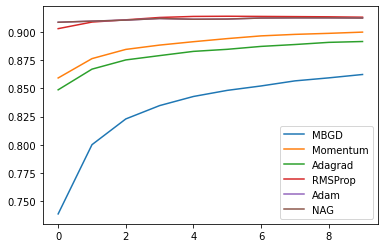

In [13]:
plt.plot([i for i in range(len(mbgd_acc_list))], mbgd_acc_list, label='MBGD')
plt.plot([i for i in range(len(momentum_acc_list))], momentum_acc_list, label='Momentum')
plt.plot([i for i in range(len(adagrad_acc_list))], adagrad_acc_list, label='Adagrad')
plt.plot([i for i in range(len(rmsprop_acc_list))], rmsprop_acc_list, label='RMSProp')
plt.plot([i for i in range(len(adam_acc_list))], adam_acc_list, label='Adam')
plt.plot([i for i in range(len(nag_acc_list))], adam_acc_list, label='NAG')

plt.legend()
plt.show()

In [ ]:
def test(model):
    batch_test_count = int(test_data.shape[0] / batch_size)
    batch_test_inputs, batch_test_targets = [], []
    for i in range(batch_test_count):
        batch_test_inputs.append(test_data[i*batch_size : (i+1)*batch_size])
        batch_test_targets.append(test_label[i*batch_size : (i+1)*batch_size])
    correct = 0
    for j in range(batch_test_count):
        inputs = cp.array(batch_test_inputs[j])
        targets = cp.array(batch_test_targets[j])

        _, out = model.forward(inputs, targets)

        correct += (cp.argmax(out, axis=1) == targets).sum()
    print('test acc: {}'.format(correct / 10000))
test(model)